1. Отладить xgboost   -   `пока дрянь, но работает))`
2. Запустить catboost regressor pyspark    -  `частично, код есть, но итог пока дрянь`
3. Осввоить Arima, SARIMA, SARIMAX   `done`
4. Разобраться со sparkts
5. Сделать модель на keras tensorflow pyspark
6. Сделать модель на prophet
7. Запустить контейнеры: clickhouse, mlflow, postgres, minio
8. Загрузить данные в clickhouse и организовать получение данных из бд
9. Настроить mlflow, добиться, чтобы все раны, метрики, параметры и модели логировались.
10.  

In [1]:
import pandas as pd
import numpy as np
import subprocess
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

from pyspark.sql import SparkSession
import pyspark.sql.functions as F
import pyspark.sql.types as T
from pyspark.sql.functions import col
from pyspark.sql import Window

import sys

# pip install fbprophet

In [2]:
co2_pd1 = (
    co2
    .load().data
    .interpolate()
)
co2_pd1.head(5)

,co2
1958-03-29,316.1
1958-04-05,317.3
1958-04-12,317.6
1958-04-19,317.5
1958-04-26,316.4


In [5]:
packages = [
    "com.clickhouse.spark:clickhouse-spark-runtime-3.4_2.12:0.8.0",
    "com.clickhouse:clickhouse-client:0.7.0",
    "com.clickhouse:clickhouse-http-client:0.7.0",
    "org.apache.httpcomponents.client5:httpclient5:5.2.1",
    "ai.catboost:catboost-spark_3.5_2.12:1.2.8",
    "com.sparkjava:spark-core:2.9.1",
    "org.slf4j:slf4j-api:2.0.0-alpha1",
    "org.slf4j:slf4j-simple:2.0.0-alpha1"
    "com.cloudera.sparkts:sparkts:0.4.1"
]

spark = (
    SparkSession
    .builder
    .master("local[*]")
    .appName("CO2 model development")
    .config("spark.sql.repl.eagerEval.enabled", True)
    .config("spark.jars.packages", ",".join(packages))
    .getOrCreate()
)

spark.conf.set("spark.sql.catalog.clickhouse", "com.clickhouse.spark.ClickHouseCatalog")
spark.conf.set("spark.sql.catalog.clickhouse.host", "127.0.0.1")
spark.conf.set("spark.sql.catalog.clickhouse.protocol", "http")
spark.conf.set("spark.sql.catalog.clickhouse.http_port", "8123")
spark.conf.set("spark.sql.catalog.clickhouse.user", "konsin1988")
spark.conf.set("spark.sql.catalog.clickhouse.password", "r13l02c1988")
spark.conf.set("spark.sql.catalog.clickhouse.database", "credit")
spark.conf.set("spark.clickhouse.write.format", "json")
spark.conf.set("spark.sql.debug.maxToStringFields", 1000)      # truncate string col with features
spark.sparkContext.setLogLevel("ERROR")

print(f"Spark version - {spark.version}")
print(f"Scala version - {spark.sparkContext._gateway.jvm.scala.util.Properties.versionString()}")

Spark version - 3.5.5
Scala version - version 2.12.18


In [3]:
sc = spark.sparkContext
sc.parallelize(range(8))

PythonRDD[1] at RDD at PythonRDD.scala:53

In [3]:
df = (
    spark
    .read.csv("data/co2_data.csv", header=True, inferSchema=True)
    .filter(F.isnotnull(col("co2")))
    .withColumn("date", col("date").cast(T.DateType()))
    .withColumn("date_existent", col("date"))
    .orderBy(col("date"))
)
df.limit(5)

date,co2,date_existent
1958-03-29,316.1,1958-03-29
1958-04-05,317.3,1958-04-05
1958-04-12,317.6,1958-04-12
1958-04-19,317.5,1958-04-19
1958-04-26,316.4,1958-04-26


## Pyspark interpolation

In [4]:
def get_all_dates(start, end):
    return [x for x in pd.date_range(start, end)]

date_range_udf = F.udf(get_all_dates, T.ArrayType(T.DateType()))

df_all_dates = (
    df
    .select(F.min(col("date")).alias("date_min"), F.max(col("date")).alias("date_max"))
    .withColumn("date", F.explode(date_range_udf(col("date_min"), col("date_max"))))
    .drop(col("date_min"), col("date_max"))
    .join(df, ["date"], "leftouter")
    .orderBy(col("date"))
)
df_all_dates.limit(5)



date,co2,date_existent
1958-03-29,316.1,1958-03-29
1958-03-30,NULL,NULL
1958-03-31,NULL,NULL
1958-04-01,NULL,NULL
1958-04-02,NULL,NULL


In [5]:
window_ff = Window.partitionBy(F.lit("0")).orderBy('date').rowsBetween(-sys.maxsize, 0)
               
window_bf = Window.partitionBy(F.lit("0")).orderBy('date').rowsBetween(0, sys.maxsize)
        
# create series containing the filled values
read_last = F.last(df_all_dates['co2'], ignorenulls=True).over(window_ff)
readtime_last = F.last(df_all_dates['date_existent'], ignorenulls=True).over(window_ff)
read_next = F.first(df_all_dates['co2'], ignorenulls=True).over(window_bf)
readtime_next = F.first(df_all_dates['date_existent'], ignorenulls=True).over(window_bf)

df_all_data = (
    df_all_dates
    .withColumn('co2_ff', read_last)
    .withColumn('date_ff', readtime_last)
    .withColumn('co2_bf', read_next)
    .withColumn('date_bf', readtime_next)
)

def interpol(x, x_prev, x_next, y_prev, y_next, y):
    if x_prev == x_next:
        return y
    else:
        m = (y_next-y_prev)/(pd.to_datetime(x_next)-pd.to_datetime(x_prev)).days
        y_interpol = y_prev + m * (pd.to_datetime(x) - pd.to_datetime(x_prev)).days
        return y_interpol

# convert function to udf
interpol_udf = F.udf(interpol, T.FloatType())   
    
# add interpolated columns to dataframe and clean up
df_filled = (
    df_all_data
        .withColumn('co2_interpol', interpol_udf('date', 'date_ff', 'date_bf', 'co2_ff', 'co2_bf', 'co2'))
        .drop('date_existent', 'date_ff', 'date_bf', 'co2', 'co2_ff', 'co2_bf')
        .withColumnRenamed('co2_interpol', 'co2')
)

df_filled.limit(5)

date,co2
1958-03-29,316.1
1958-03-30,316.27142
1958-03-31,316.44287
1958-04-01,316.6143
1958-04-02,316.7857


# Plot data

In [8]:
co2_pd = (
    df_filled
    .toPandas()
    .set_index('date')
)
co2_pd.head(5)

,co2
date,
1958-03-29,316.100006
1958-03-30,316.271423
1958-03-31,316.442871
1958-04-01,316.614288
1958-04-02,316.785706


# Estimation the forecastability of a time series (Approximate Entropy and Sample Entropy)

In [15]:
# https://en.wikipedia.org/wiki/Approximate_entropy
def ApEn(U, m, r):
    """Compute Aproximate entropy"""
    def _maxdist(x_i, x_j):
        return max([abs(ua - va) for ua, va in zip(x_i, x_j)])

    def _phi(m):
        x = [[U[j] for j in range(i, i + m - 1 + 1)] for i in range(N - m + 1)]
        C = [len([1 for x_j in x if _maxdist(x_i, x_j) <= r]) / (N - m + 1.0) for x_i in x]
        return (N - m + 1.0)**(-1) * sum(np.log(C))

    N = len(U)
    return abs(_phi(m+1) - _phi(m))

print(ApEn(co2_pd1['co2'].values, m=2, r=0.2*np.std(co2_pd1['co2'].values)))

0.0645148681327754


In [16]:
def SampEn(U, m, r):
    """Compute Sample entropy"""
    def _maxdist(x_i, x_j):
        return max([abs(ua - va) for ua, va in zip(x_i, x_j)])

    def _phi(m):
        x = [[U[j] for j in range(i, i + m - 1 + 1)] for i in range(N - m + 1)]
        C = [len([1 for j in range(len(x)) if i != j and _maxdist(x[i], x[j]) <= r]) for i in range(len(x))]
        return sum(C)

    N = len(U)
    return -np.log(_phi(m+1) / _phi(m))

print(SampEn(co2_pd1['co2'].values, m=2, r=0.2*np.std(co2_pd1['co2'].values)))   

0.06400240893169706


# Autocorrelation
It measures how the current value of a time series correlates with past values

##### Two common tools:
- The autocorrelation function (ACF) plot;
- The partial autocorrelation function (PACF) plot

### ACF

- A high absolute value of ACF at certain lags indicates a strong autocorrelation at those lags.
- If ACF values drop off quickly to zero, it suggests that the time series does not have significant linear trends or seasonality.
- Slow decay in the ACF might indicate a non-stationary series.
- ACF is used in time series analysis to identify potential AR (AutoRegressive) components in ARIMA modeling.
- Helpful in determining the need for differencing to achieve stationarity.


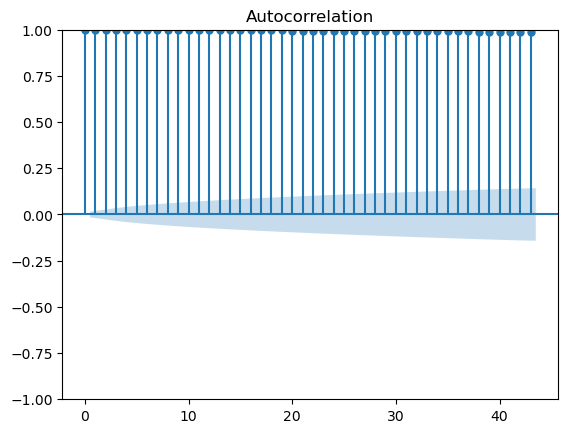

In [89]:
from statsmodels.graphics.tsaplots import plot_acf


plot_acf(co2_pd);

```This plot clearly shows significant autocorrelation```

### PACF

PACF measures the correlation of a time series with its own lagged values, but after removing the effects of shorter lag correlations. It isolates the correlation at each lag.

- Significant spikes in the PACF at specific lags indicate potential AR terms in an ARIMA model.
- PACF helps in identifying the order of the AR term (p) in an ARIMA model.
- PACF is crucial in model selection for time series analysis, particularly for identifying the appropriate AR terms.
- It's used when a series is suspected to be autoregressive.


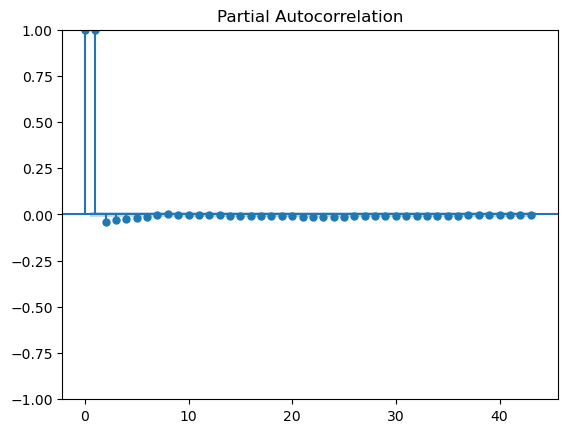

In [96]:
from statsmodels.graphics.tsaplots import plot_pacf

plot_pacf(co2_pd);

### Cross Correlation

```Cross correlation measures the relationship between two different time series at different lags. It explores how past values of one series relate to the current value of another series and vice versa.```

- Positive lags in cross-correlation show how past values of one time series (X) relate to the future values of another series (Y).
- Negative lags show how past values of the target series (Y) relate to the future values of another series (X).
- Significant values at specific lags (positive or negative) can indicate a lead-lag relationship between the series.
- Used in multivariate time series analysis to understand the dynamic relationships between different variables.
- Essential in identifying leading or lagging indicators for a target variable.
- Helps in feature selection and model development in forecasting scenarios where multiple time-dependent variables interact.


In [1]:
from statsmodels.tsa.stattools import ccf  

# Autocorrelation in pyspark

In [ ]:
window_spec = Window.partitionBy(F.lit("0")).orderBy("date")
autocorr_data = [df_filled.withColumn("co2_lagged", F.lag(col("co2"), x).over(window_spec)).select(F.corr(col("co2"), col("co2_lagged")).alias("correlation")).collect()[0][0] for x in range(1, 40)]

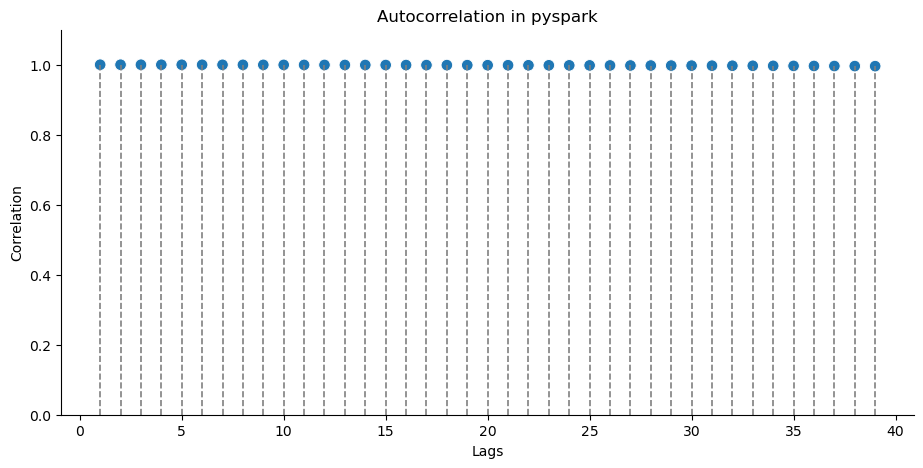

In [200]:
data = pd.DataFrame({"lag": range(1, 40), "corr": autocorr_data}).set_index('lag')

fig, ax = plt.subplots(figsize=(11, 5))
sns.scatterplot(data, s=70)
plt.ylim([0, 1.1])
plt.vlines(x=data.index, ymin=0,ymax=data['corr'], colors='gray', linestyle='dashed', linewidth=1.2)
plt.legend().set_visible(False)
plt.title("Autocorrelation in pyspark")
plt.ylabel("Correlation")
plt.xlabel("Lags")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# plt.grid(True)
plt.show()

## Lag plots

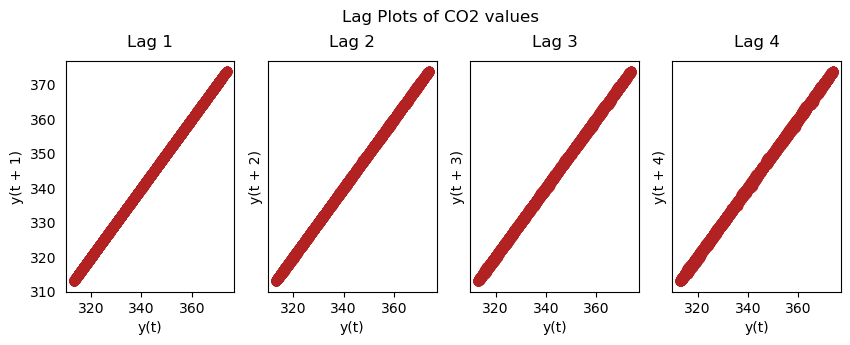

In [10]:
from pandas.plotting import lag_plot

plt.rcParams.update({'ytick.left' : False, 'axes.titlepad':10})

# Plot
fig, axes = plt.subplots(1, 4, figsize=(10,3), sharex=True, sharey=True, dpi=100)
for i, ax in enumerate(axes.flatten()[:4]):
    lag_plot(co2_pd['co2'], lag=i+1, ax=ax, c='firebrick')
    ax.set_title('Lag ' + str(i+1))

fig.suptitle('Lag Plots of CO2 values', y=1.05)    
plt.show()

# Stationarity

### Transformations to make the time-series stationary


1. Differencing the Series (once or more)
2. Take the log of the series
3. Take the nth root of the series
4. Combination of the above


### Reasons to convert a non-stationary series into stationary one before forecasting


1. Forecasting a stationary series is relatively easy and the forecasts are more reliable.
2. An important reason is, autoregressive forecasting models are essentially linear regression models that utilize the lag(s) of the series itself as predictors.
3. We know that linear regression works best if the predictors (X variables) are not correlated against each other. So, stationarizing the series solves this problem since it removes any persistent autocorrelation, thereby making the predictors(lags of the series) in the forecasting models nearly independent.


### Tests for stationarity (Unit Root tests)

1. Augmented Dickey Fuller test (ADF Test)
2. Kwiatkowski-Phillips-Schmidt-Shin – KPSS test (trend stationary)
3. Philips Perron test (PP Test)

## Augmented Dickey Fuller test (ADF Test) 
The most commonly used. Here, we assume that the null hypothesis is the time series possesses a unit root and is non-stationary. Then, we collect evidence to support or reject the null hypothesis. So, if we find that the p-value in ADF test is less than the significance level (0.05), we reject the null hypothesis

In [30]:
from statsmodels.tsa.stattools import adfuller

adf, pval, usedlag, nobs, crit_vals, icbest = adfuller(co2_pd.values)

print('ADF test statistic: ', adf)
print('ADF p-value: ', pval)
print('Number of lags used: ', usedlag)
print('Number of observations: ', nobs)
print('Critical values: ', crit_vals)
print('Best information criterion: ', icbest)

ADF test statistic:  -1.4634650406970742
ADF p-value:  0.5515010829672018
Number of lags used:  43
Number of observations:  15938
Critical values:  {'1%': -3.4307603622486433, '5%': -2.861721363145441, '10%': -2.56686653508881}
Best information criterion:  -73137.92436753701


## Kwiatkowski-Phillips-Schmidt-Shin – KPSS test (trend stationary) 
The KPSS test, on the other hand, is used to test for trend stationarity. The null hypothesis and the P-Value interpretation is just the opposite of ADH test.

In [11]:
from statsmodels.tsa.stattools import kpss

kpss_statistic, p_value, n_lags, critical_values = kpss(co2_pd)
print("Kwiatkowski-Phillips-Schmidt-Shin – KPSS test results")
print("kpss_statistic: ", kpss_statistic)
print("p_value: ", p_value)
print("n_lags: ", n_lags)
print("critical_values: ", critical_values)

Kwiatkowski-Phillips-Schmidt-Shin – KPSS test results
kpss_statistic:  20.80754990475603
p_value:  0.01
n_lags:  75
critical_values:  {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}


/tmp/ipykernel_16453/1169512522.py:3: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_statistic, p_value, n_lags, critical_values = kpss(co2_pd)


### Philips Perron test (PP Test)
It is used in the time series analysis to test the null hypothesis that a time series is integrated of order 1. It is built on the ADF test discussed above.

In [44]:
from arch.unitroot import PhillipsPerron as pp

pp(np.diff(np.log(co2_pd["co2"])))

Test Statistic,-34.468
P-value,0.000
Lags,43


# Detrend a Time Series

Detrending a time series means to remove the trend component from the time series. There are multiple approaches of doing this as listed below:

1. Subtract the line of best fit from the time series. The line of best fit may be obtained from a linear regression model with the time steps as the predictor. For more complex trends, we may want to use quadratic terms (x^2) in the model.
2. We subtract the trend component obtained from time series decomposition.
3. Subtract the mean.
4. Apply a filter like Baxter-King filter(statsmodels.tsa.filters.bkfilter) or the Hodrick-Prescott Filter (statsmodels.tsa.filters.hpfilter) to remove the moving average trend lines or the cyclical components.

#### Subtraction the line of best fit from the time series

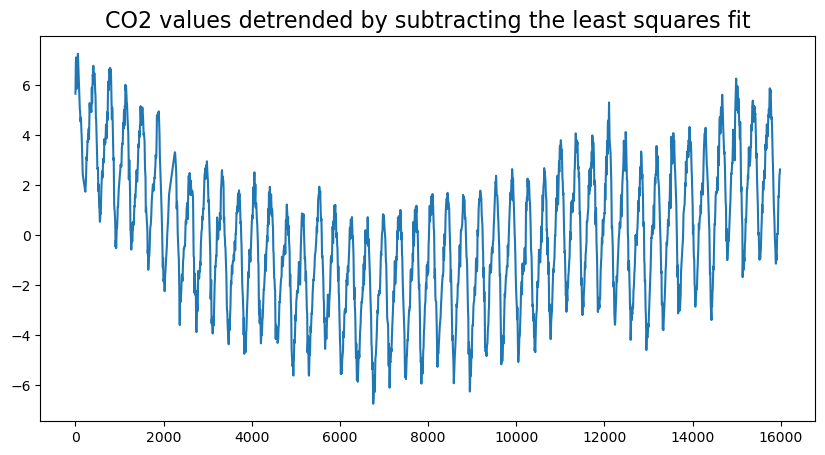

In [47]:
from scipy import signal

detrended = signal.detrend(co2_pd["co2"].values)
plt.plot(detrended)
plt.title('CO2 values detrended by subtracting the least squares fit', fontsize=16);

#### Subtraction the trend component obtained from time series decomposition

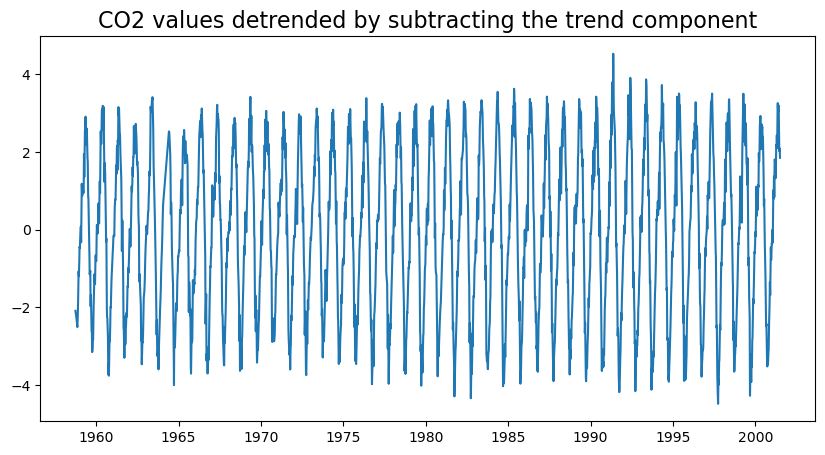

In [65]:
from statsmodels.tsa.seasonal import seasonal_decompose

additive_decomposition = seasonal_decompose(co2_pd['co2'], model="additive", period=365)
detrended = co2_pd["co2"].values - additive_decomposition.trend
plt.plot(detrended)
plt.title('CO2 values detrended by subtracting the trend component', fontsize=16);

# Boxplot of Month-wise (Seasonal) and Year-wise (trend) Distribution

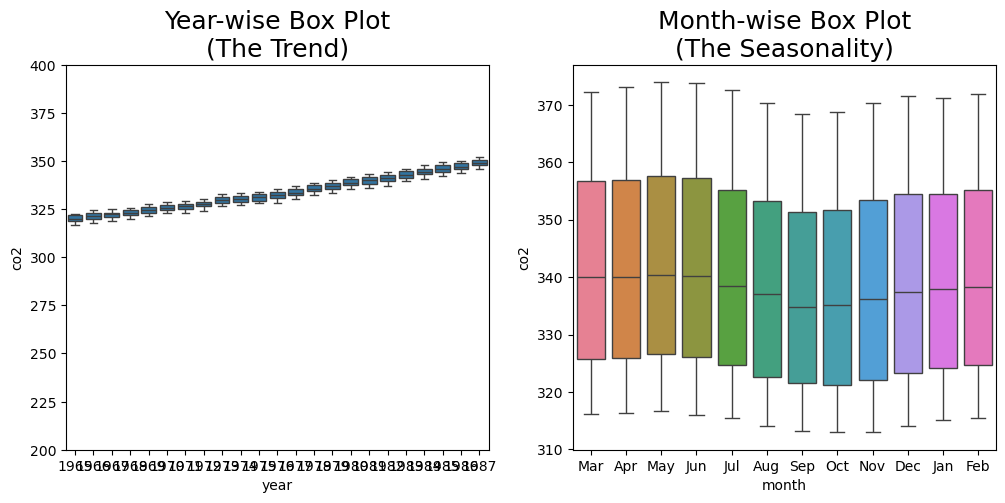

In [57]:
co2_mon_year = (
    co2_pd
    .reset_index()
    .assign(date = lambda x: x.date.astype("datetime64[ns]"))
    .assign(month = lambda x: x.date.dt.strftime('%b'))
    .assign(year = lambda x: x.date.dt.year)
)
years = co2_mon_year['year'].unique()

fig, axes = plt.subplots(1, 2, figsize=(12,5), dpi= 100)
sns.boxplot(x='year', y='co2', data=co2_mon_year.query(f'year in {[x for x in range(1965, 1988)]}'), ax=axes[0])
sns.boxplot(x='month', y='co2', hue='month', data=co2_mon_year)

axes[0].set_title('Year-wise Box Plot\n(The Trend)', fontsize=18); 
axes[1].set_title('Month-wise Box Plot\n(The Seasonality)', fontsize=18)
axes[0].set_ylim([200, 400])
plt.show()

# Seasonal decomposition
```Decompose data into trend, seasonality and noise```

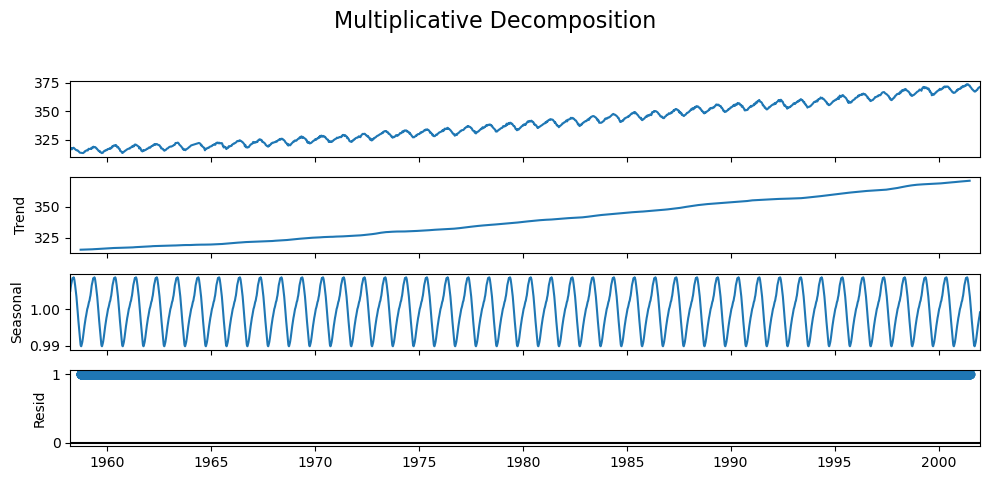

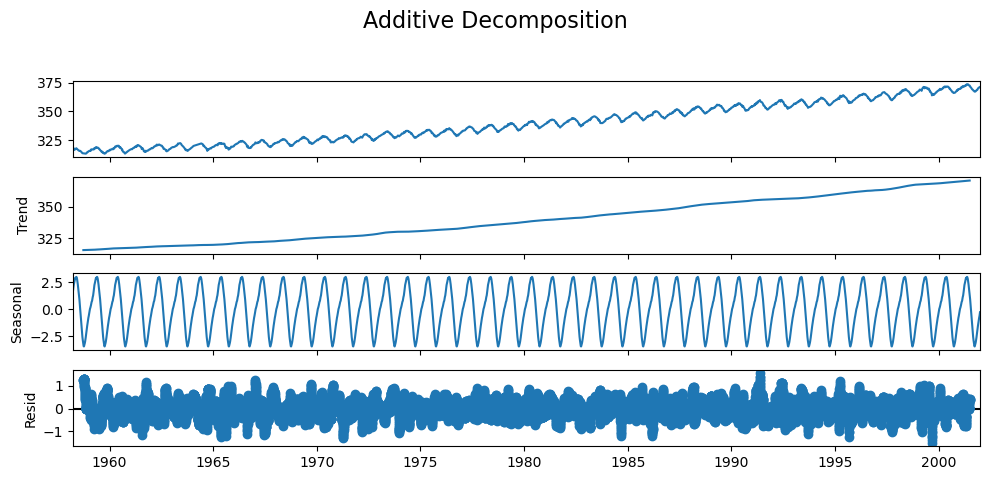

In [81]:
from statsmodels.tsa.seasonal import seasonal_decompose
multiplicative_decomposition = seasonal_decompose(co2_pd, model='multiplicative', period=365)
additive_decomposition = seasonal_decompose(co2_pd, model='additive', period=365)

plt.rcParams.update({'figure.figsize': (10,5)})
multiplicative_decomposition.plot().suptitle('Multiplicative Decomposition', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

additive_decomposition.plot().suptitle('Additive Decomposition', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.show()

## Test for seasonality

<AxesSubplot: xlabel='Lag', ylabel='Autocorrelation'>

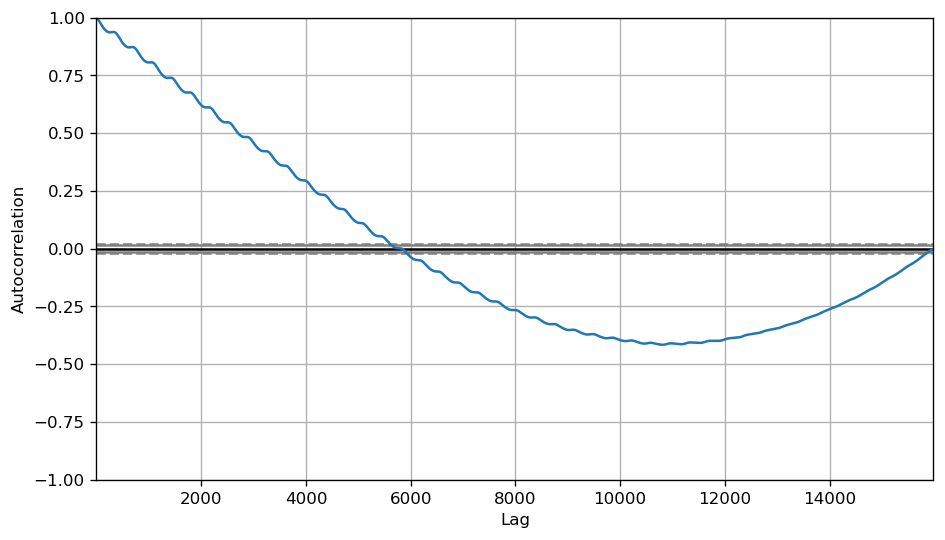

In [83]:
from pandas.plotting import autocorrelation_plot

plt.rcParams.update({'figure.figsize':(9,5), 'figure.dpi':120})
autocorrelation_plot(co2_pd['co2'].tolist())

# Deseasonalize a Time Series

Approaches to deseasonalize a time series:

1. Take a moving average with length as the seasonal window. This will smoothen in series in the process.
2. Seasonal difference the series (subtract the value of previous season from the current value).
3. Divide the series by the seasonal index obtained from STL decomposition.

> If dividing by the seasonal index does not work well, we will take a log of the series and then do the deseasonalizing. We will later restore to the original scale by taking an exponential.

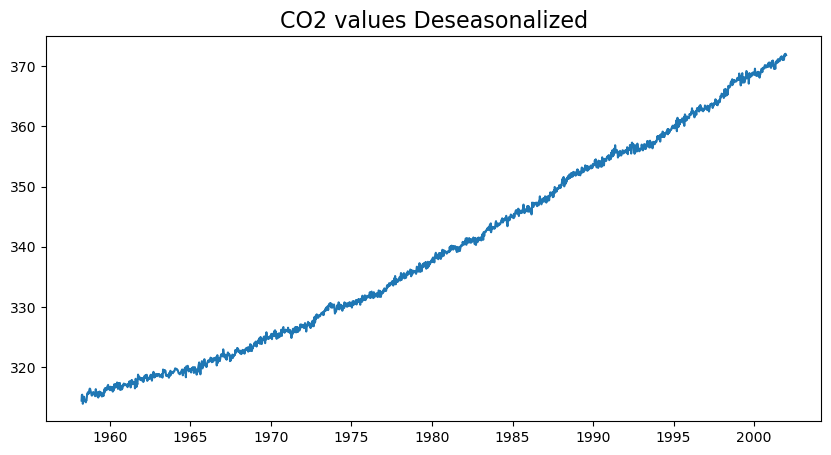

In [80]:
from statsmodels.tsa.seasonal import seasonal_decompose

additive_decomposition = seasonal_decompose(co2_pd['co2'], model="multiplicative", period=365)
deseasonalized = co2_pd['co2'].values / additive_decomposition.seasonal
plt.plot(deseasonalized)
plt.title('CO2 values Deseasonalized', fontsize=16);

# Granger Causality Test 

Table of Contents:

    Granger causality test is used to determine if one time series will be useful to forecast another. It is based on the idea that if X causes Y, then the forecast of Y based on previous values of Y AND the previous values of X should outperform the forecast of Y based on previous values of Y alone.

    So, Granger causality test should not be used to test if a lag of Y causes Y. Instead, it is generally used on exogenous (not Y lag) variables only. It is implemented in the statsmodel package.

    It accepts a 2D array with 2 columns as the main argument. The values are in the first column and the predictor (X) is in the second column. The Null hypothesis is that the series in the second column, does not Granger cause the series in the first. If the P-Values are less than a significance level (0.05) then we reject the null hypothesis and conclude that the said lag of X is indeed useful. The second argument maxlag says till how many lags of Y should be included in the test.


In [12]:
from statsmodels.tsa.stattools import grangercausalitytests

co2_with_months = (
    co2_pd
    .reset_index()
    .assign(month = lambda x: x['date'].astype('datetime64[ns]').dt.month)
)
grangercausalitytests(co2_with_months[['co2', 'month']], maxlag=2)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=41.1732 , p=0.0000  , df_denom=15978, df_num=1
ssr based chi2 test:   chi2=41.1809 , p=0.0000  , df=1
likelihood ratio test: chi2=41.1279 , p=0.0000  , df=1
parameter F test:         F=41.1732 , p=0.0000  , df_denom=15978, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.5204  , p=0.5943  , df_denom=15975, df_num=2
ssr based chi2 test:   chi2=1.0411  , p=0.5942  , df=2
likelihood ratio test: chi2=1.0411  , p=0.5942  , df=2
parameter F test:         F=0.5204  , p=0.5943  , df_denom=15975, df_num=2


{1: ({'ssr_ftest': (41.17315399990003, 1.432437576453514e-10, 15978.0, 1),
   'ssr_chi2test': (41.18088459584444, 1.3877307822217697e-10, 1),
   'lrtest': (41.12791677365021, 1.4258516529348194e-10, 1),
   'params_ftest': (41.17315400317048, 1.432437574062993e-10, 15978.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (0.5203940704169425, 0.594296385215149, 15975.0, 2),
   'ssr_chi2test': (1.041113896120531, 0.5941895230946024, 2),
   'lrtest': (1.041079982824158, 0.5941995986427251, 2),
   'params_ftest': (0.520394071341894, 0.5942963846654348, 15975.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])])}

# Why and How to smoothen a time series

- Reducing the effect of noise in a signal get a fair approximation of the noise-filtered series.
- The smoothed version of series can be used as a feature to explain the original series itself.
- Visualize the underlying trend better

#### Methods:

1. Take a moving average
2. Do a LOESS smoothing (Localized Regression)
3. Do a LOWESS smoothing (Locally Weighted Regression)

> Moving average is nothing but the average of a rolling window of defined width. But you must choose the window-width wisely, because, large window-size will over-smooth the series. For example, a window-size equal to the seasonal duration (ex: 12 for a month-wise series), will effectively nullify the seasonal effect.

> LOESS, short for ‘LOcalized regrESSion’ fits multiple regressions in the local neighborhood of each point. It is implemented in the statsmodels package, where you can control the degree of smoothing using frac argument which specifies the percentage of data points nearby that should be considered to fit a regression model.

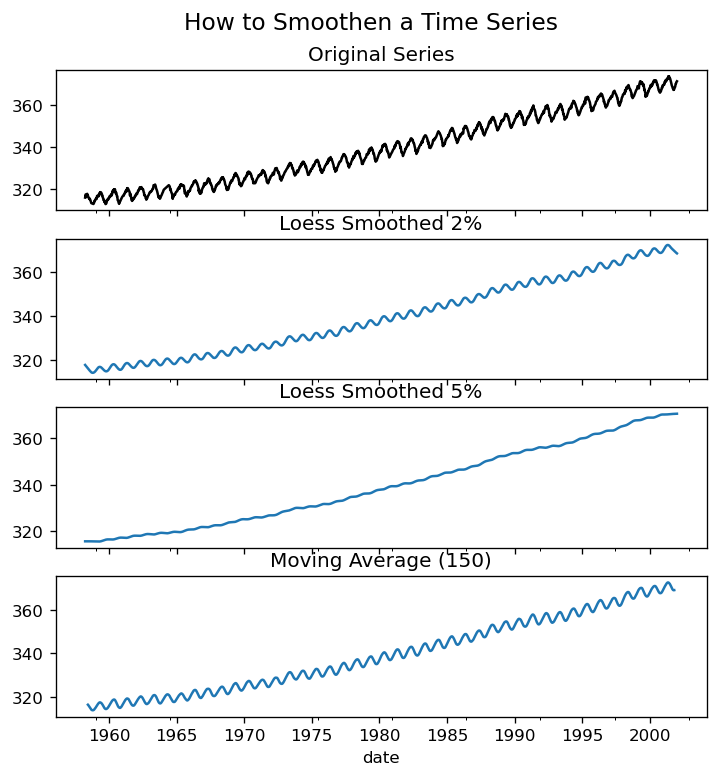

In [33]:
from statsmodels.nonparametric.smoothers_lowess import lowess

# moving average
co2_ma = co2_pd['co2'].rolling(150, center=True, closed='both').mean()

# Loess Smoothing (5% and 15%)
co2_loess_5 = pd.DataFrame(lowess(co2_pd['co2'].values, np.arange(len(co2_pd['co2'].values)), frac=0.02)[:, 1], index=co2_pd.index, columns=['co2'])
co2_loess_15 = pd.DataFrame(lowess(co2_pd['co2'].values, np.arange(len(co2_pd['co2'].values)), frac=0.05)[:, 1], index=co2_pd.index, columns=['co2'])

fig, axes = plt.subplots(4,1, figsize=(7, 7), sharex=True, dpi=120)
co2_pd['co2'].plot(ax=axes[0], color='k', title='Original Series')
co2_loess_5['co2'].plot(ax=axes[1], title='Loess Smoothed 2%')
co2_loess_15['co2'].plot(ax=axes[2], title='Loess Smoothed 5%')
co2_ma.plot(ax=axes[3], title='Moving Average (150)')
fig.suptitle('How to Smoothen a Time Series', y=0.95, fontsize=14)
plt.show()

# Features 

In [108]:
window = Window.partitionBy(F.lit(0)).orderBy(col("date").asc())
window_1m_rolling = Window.partitionBy(F.lit(0)).orderBy(col("date").asc()).rowsBetween(Window.currentRow - 30, Window.currentRow)
window_1y_rolling = Window.partitionBy(F.lit(0)).orderBy(col("date").asc()).rowsBetween(Window.currentRow - 365, Window.currentRow)

df_features = (
    df_filled
    .withColumns({"dt_month": F.month(col("date")),
                  "dt_year": F.year(col("date")),
                  # "dt_day_of_w": F.dayofweek(col("date")),
                  # "dt_day_of_m": F.day(col("date")),
                  "dt_day_of_y": F.dayofyear(col("date")),
                  # "dt_week_of_y": F.weekofyear(col("date")),
                  # "dt_is_wknd": F.dayofweek(col("date")).isin([7,1]).cast(T.IntegerType()),
                  "dt_quarter": F.quarter(col("date"))
                 })
    .withColumns({
                  # "lagged_co2_1d": F.lag(col("co2"), 1).over(window),
                  # "lagged_co2_2d": F.lag(col("co2"), 2).over(window),
                  # "lagged_co2_3d": F.lag(col("co2"), 3).over(window),
                  # "lagged_co2_1m": F.lag(col("co2"), 30).over(window),
                  # "lagged_co2_1m_1d": F.lag(col("co2"), 30+1).over(window),
                  "lagged_co2_1y": F.lag(col("co2"), 365).over(window),
                  "lagged_co2_1y_1d": F.lag(col("co2"), 365+1).over(window),
                  # "lagged_mean_1m": F.round(F.mean(F.lag(col("co2"), 1).over(window)).over(window_1m_rolling), 4),
                  # "lagged_max_1m": F.max(F.lag(col("co2"), 1).over(window)).over(window_1m_rolling),
                  # "lagged_min_1m": F.min(F.lag(col("co2"), 1).over(window)).over(window_1m_rolling),
                  "lagged_mean_1y": F.round(F.mean(F.lag(col("co2"), 1).over(window)).over(window_1y_rolling), 4),
                  "lagged_max_1y": F.max(F.lag(col("co2"), 1).over(window)).over(window_1y_rolling),
                  "lagged_min_1y": F.min(F.lag(col("co2"), 1).over(window)).over(window_1y_rolling)
                 })
    .dropna(how='any')
    # .withColumn("rank", F.round(F.percent_rank().over(window), 2))
    .withColumnRenamed("co2", "label")
)
df_features.limit(5)

date,label,dt_month,dt_year,dt_day_of_y,dt_quarter,lagged_co2_1y,lagged_co2_1y_1d,lagged_mean_1y,lagged_max_1y,lagged_min_1y
1959-03-30,316.98572,3,1959,89,1,316.27142,316.1,315.4258,317.9,313.0
1959-03-31,317.12857,3,1959,90,1,316.44287,316.27142,315.4282,317.9,313.0
1959-04-01,317.27142,4,1959,91,2,316.6143,316.44287,315.4306,317.9,313.0
1959-04-02,317.41428,4,1959,92,2,316.7857,316.6143,315.4328,317.9,313.0
1959-04-03,317.55713,4,1959,93,2,316.95715,316.7857,315.435,317.9,313.0


## Train test split

In [31]:
df_train = df_features.filter(col('dt_year').isin([F.lit(x) for x in range(1959, 1989)]))
df_test = df_features.filter(col('dt_year').isin([F.lit(x) for x in range(1989, 2000)]))

# Linear regression (pyspark)

In [32]:
from pyspark.ml.feature import StringIndexer, VectorAssembler, StandardScaler, OneHotEncoder, VectorIndexer
from pyspark.ml import Pipeline
from pyspark.ml.regression import LinearRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import RegressionEvaluator


stages = []

FEATURES = [i for i in df_features.columns if i.startswith("dt")] + [i for i in df_features.columns if i.startswith("lagged")]

assembler = VectorAssembler(inputCols=FEATURES, outputCol="features")
stages += [assembler]

# vector_indexer = VectorIndexer(inputCol=assembler.getOutputCol(), outputCol="features", maxCategories=367)
# stages += [vector_indexer]

lr = LinearRegression(featuresCol="features", 
                             labelCol="label", 
                             predictionCol="prediction",
                             regParam=0.1, 
                             elasticNetParam=0.3
                            )

paramGrid = (
    ParamGridBuilder()
        .addGrid(lr.regParam, [0.1, 0.3])
        .addGrid(lr.elasticNetParam, [0.3, 0.5])
        .build()
)

evaluator = RegressionEvaluator(metricName="rmse",
                                labelCol=lr.getLabelCol(),
                                predictionCol=lr.getPredictionCol())

cv = CrossValidator(estimator=lr, evaluator=evaluator, estimatorParamMaps=paramGrid)
stages += [cv]

pipeline = Pipeline(stages=stages)

In [33]:
model = pipeline.fit(df_train)
prediction = model.transform(df_test)

In [28]:
model.stages[-1].getEstimatorParamMaps()

[{Param(parent='LinearRegression_aee353674025', name='regParam', doc='regularization parameter (>= 0).'): 0.1,
  Param(parent='LinearRegression_aee353674025', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'): 0.3},
 {Param(parent='LinearRegression_aee353674025', name='regParam', doc='regularization parameter (>= 0).'): 0.1,
  Param(parent='LinearRegression_aee353674025', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'): 0.5},
 {Param(parent='LinearRegression_aee353674025', name='regParam', doc='regularization parameter (>= 0).'): 0.3,
  Param(parent='LinearRegression_aee353674025', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'): 0.3},
 {Param(parent='

In [10]:
# pd.DataFrame(prediction.select(col("date"), col("prediction")).collect(), columns=['date', 'prediction'])
# df_test.count()
df_train.select(col('dt_year')).groupBy(col('dt_year')).count().orderBy(col('dt_year')).select(F.max(col('dt_year')))

max(dt_year)
1988


In [34]:
train_pd = df_train.select(col("date"), col("label")).toPandas().set_index('date')
test_pd = df_test.select(col("date"), col("label")).toPandas().set_index('date')
pred_pd = prediction.select(col("date"), col("prediction")).toPandas().set_index('date')

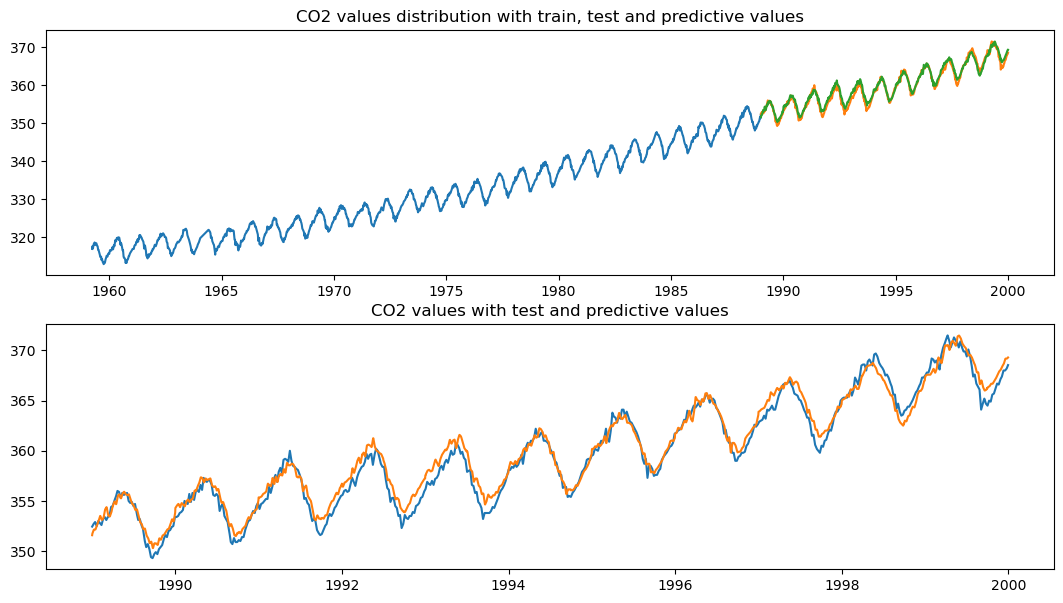

In [35]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(13, 7))
ax1.plot(train_pd)
ax1.plot(test_pd)
ax1.plot(pred_pd)
ax2.plot(test_pd)
ax2.plot(pred_pd)

ax1.set_title("CO2 values distribution with train, test and predictive values")
ax2.set_title("CO2 values with test and predictive values")
plt.show();

# Prediction amount of CO2 to 2002 year with linear regression model

In [38]:
df_prev = (
    df_filled
    .filter(F.year(col("date")) == 2001)
    .withColumns({
        "lagged_co2_1y_1d": F.lag(col("co2"), 1).over(window),
        "lagged_co2_1y": col('co2'),
        "date": F.add_months(col("date"), 12),
        "lagged_mean_1y": F.round(F.mean(F.lag(col("co2"), 1).over(window)).over(window_1y_rolling), 4),
        "lagged_max_1y": F.max(F.lag(col("co2"), 1).over(window)).over(window_1y_rolling),
        "lagged_min_1y": F.min(F.lag(col("co2"), 1).over(window)).over(window_1y_rolling)
    })
    .withColumns({"dt_month": F.month(col("date")),
                  "dt_year": F.year(col("date")),
                  "dt_day_of_w": F.dayofweek(col("date")),
                  "dt_day_of_m": F.day(col("date")),
                  "dt_day_of_y": F.dayofyear(col("date")),
                  "dt_week_of_y": F.weekofyear(col("date")),
                  "dt_is_wknd": F.dayofweek(col("date")).isin([7,1]).cast(T.IntegerType()),
                  "dt_quarter": F.quarter(col("date"))
                 })
    .dropna(how='any')
)


df_prev.limit(5)

date,co2,lagged_co2_1y_1d,lagged_co2_1y,lagged_mean_1y,lagged_max_1y,lagged_min_1y,dt_month,dt_year,dt_day_of_w,dt_day_of_m,dt_day_of_y,dt_week_of_y,dt_is_wknd,dt_quarter
2002-01-02,369.8,369.8,369.8,369.8,369.8,369.8,1,2002,4,2,2,1,0,1
2002-01-03,369.8,369.8,369.8,369.8,369.8,369.8,1,2002,5,3,3,1,0,1
2002-01-04,369.8,369.8,369.8,369.8,369.8,369.8,1,2002,6,4,4,1,0,1
2002-01-05,369.8,369.8,369.8,369.8,369.8,369.8,1,2002,7,5,5,1,1,1
2002-01-06,369.8,369.8,369.8,369.8,369.8,369.8,1,2002,1,6,6,1,1,1


In [43]:
prediction_2002 = model.transform(df_prev)
pred_pd_2002 = prediction_2002.select(col("date"), col("prediction")).toPandas().set_index('date')
test_pd = df_features.filter(col('dt_year').isin([F.lit(x) for x in range(1995, 2002)])).select(col("date"), col("label")).toPandas().set_index('date')

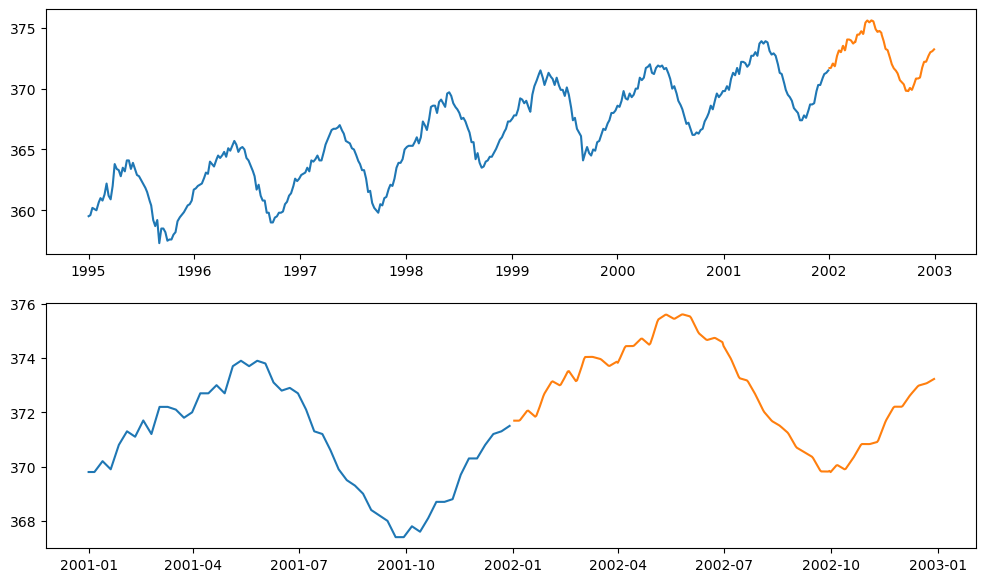

In [44]:
fig, (ax, ax2) = plt.subplots(2, 1, figsize=(12, 7))
ax.plot(test_pd)
ax.plot(pred_pd_2002)
ax2.plot(test_pd.reset_index().assign(date = lambda x: x.date.astype('datetime64[ns]')).query("date.dt.year == 2001").set_index('date'))
ax2.plot(pred_pd_2002)
plt.show();

# Forecasting with XGBOOST 

In [87]:
from xgboost.spark import SparkXGBRegressor
from pyspark.ml.feature import StringIndexer, VectorAssembler, StandardScaler, OneHotEncoder, VectorIndexer
from pyspark.ml import Pipeline
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import RegressionEvaluator

stages = []

FEATURES = [i for i in df_features.columns if i.startswith("dt")] + [i for i in df_features.columns if i.startswith("lagged")]

assembler = VectorAssembler(inputCols=FEATURES, outputCol="features")
stages += [assembler]

# vector_indexer = VectorIndexer(inputCol="rawFeatures", outputCol="features", maxCategories=367)
# stages += [vector_indexer]

xgb_regressor = SparkXGBRegressor(features_col="features",
                              label_col="label",
                              num_workers=sc.defaultParallelism,
                              max_leaves=5,
                              # booster="gbtree",
                              max_depth=10,
                              n_estimators=10,
                              learning_rate=0.1
                            )
stages += [xgb_regressor]

# paramGrid = (
#     ParamGridBuilder()
#         .addGrid(xgb_regressor.max_depth, [5, 10])
#         .addGrid(xgb_regressor.n_estimators, [10, 50])
#         .build()
# )

# evaluator = RegressionEvaluator(metricName="rmse",
#                                 labelCol=xgb_regressor.getLabelCol(),
#                                 predictionCol=xgb_regressor.getPredictionCol())

# cv = CrossValidator(estimator=xgb_regressor, evaluator=evaluator, estimatorParamMaps=paramGrid)
# stages += [cv]

pipeline = Pipeline(stages=stages)

In [88]:
xgb_model = pipeline.fit(df_train)
prediction = xgb_model.transform(df_test)

2025-07-02 21:54:45,811 INFO XGBoost-PySpark: _fit Running xgboost-2.1.3 on 12 workers with
	booster params: {'objective': 'reg:squarederror', 'device': 'cpu', 'learning_rate': 0.1, 'max_depth': 10, 'max_leaves': 5, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2025-07-02 21:54:53,353 INFO XGBoost-PySpark: _train_booster Training on CPUs12]
[21:54:54] Task 5 got rank 7[21:54:54] Task 6 got rank 8
[21:54:54] Task 7 got rank 9
[21:54:54] Task 2 got rank 4
[21:54:54] Task 4 got rank 6[21:54:54] Task 8 got rank 10
[21:54:54] Task 1 got rank 1
[21:54:54] Task 11 got rank 3
[21:54:54] Task 3 got rank 5
[21:54:54] Task 10 got rank 2
[21:54:54] Task 0 got rank 0

[21:54:54] Task 9 got rank 11

2025-07-02 21:54:56,416 INFO XGBoost-PySpark: _fit Finished xgboost training!   


In [89]:
train_pd = df_train.select(col("date"), col("label")).toPandas().set_index('date')
test_pd = df_test.select(col("date"), col("label")).toPandas().set_index('date')
pred_pd = prediction.select(col("date"), col("prediction")).toPandas().set_index('date')

2025-07-02 21:55:20,252 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs
                                                                                

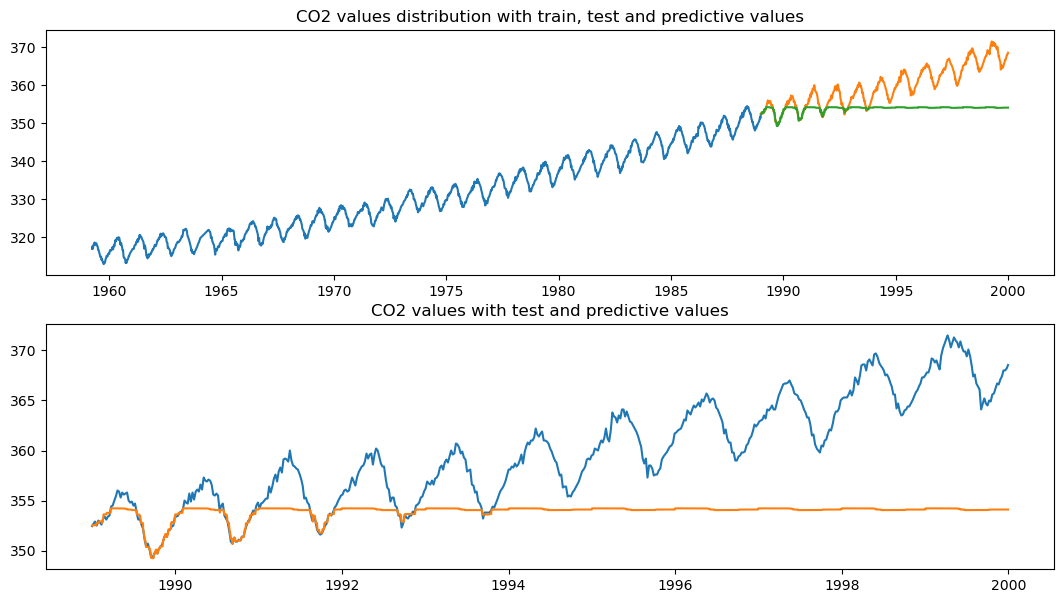

In [90]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(13, 7))
ax1.plot(train_pd)
ax1.plot(test_pd)
ax1.plot(pred_pd)
ax2.plot(test_pd)
ax2.plot(pred_pd)

ax1.set_title("CO2 values distribution with train, test and predictive values")
ax2.set_title("CO2 values with test and predictive values")
plt.show();

# Catboost regressor

In [111]:
import catboost_spark
from catboost_spark import CatBoostRegressor
from pyspark.ml.feature import StringIndexer, VectorAssembler, StandardScaler, OneHotEncoder, VectorIndexer
from pyspark.ml import Pipeline
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import RegressionEvaluator

stages = []

FEATURES = [i for i in df_features.columns if i.startswith("dt")] + [i for i in df_features.columns if i.startswith("lagged")]

assembler = VectorAssembler(inputCols=FEATURES, outputCol="ass_features")
stages += [assembler]

vector_indexer = VectorIndexer(inputCol="ass_features", outputCol="features", maxCategories=2)
stages += [vector_indexer]

# paramGrid = (
#     ParamGridBuilder()
#         .addGrid(cb_regressor.iterations, [2, 5])
#         # .addGrid(cb_regressor.l2LeafReg, [2.0, 3.5])
#         .build()
# )

# evaluator = RegressionEvaluator(metricName="rmse",
#                                 labelCol=cb_regressor.getLabelCol(),
#                                 predictionCol=cb_regressor.getPredictionCol())

# cv = CrossValidator(estimator=cb_regressor, evaluator=evaluator, estimatorParamMaps=paramGrid)
# stages += [cv]

pipeline = Pipeline(stages=stages)

In [112]:
df_prep = pipeline.fit(df_features).transform(df_features)

In [113]:
df_train = df_prep.filter(col('dt_year').isin([F.lit(x) for x in range(1959, 1989)]))
df_test = df_prep.filter(col('dt_year').isin([F.lit(x) for x in range(1989, 2000)]))

In [114]:
cb_regressor = CatBoostRegressor(featuresCol="features", 
                                 labelCol="label", 
                                 predictionCol='prediction', 
                                 iterations=200, 
                                 learningRate=0.5, 
                                 depth=2,
                                 lossFunction='RMSE',
                                 evalMetric='MAE'
                                )

In [ ]:
cb_model = cb_regressor.fit(df_train)

In [116]:
prediction = cb_model.transform(df_test)

[Stage 23860:>                                                      (0 + 1) / 1]

In [117]:
train_pd = df_train.select(col("date"), col("label")).toPandas().set_index('date')
test_pd = df_test.select(col("date"), col("label")).toPandas().set_index('date')
pred_pd = prediction.select(col("date"), col("prediction")).toPandas().set_index('date')

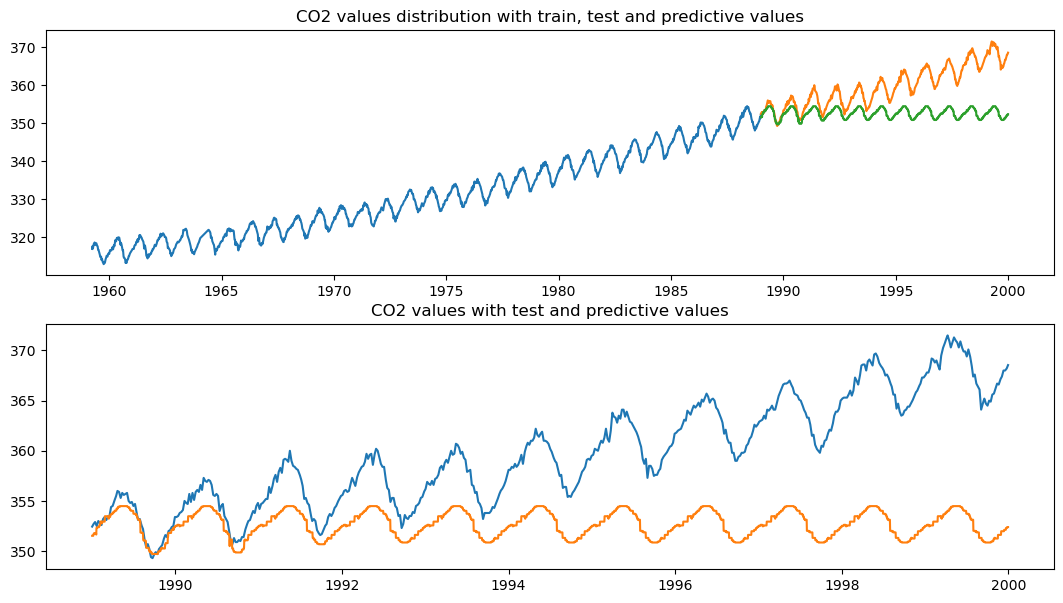

In [118]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(13, 7))
ax1.plot(train_pd)
ax1.plot(test_pd)
ax1.plot(pred_pd)
ax2.plot(test_pd)
ax2.plot(pred_pd)

ax1.set_title("CO2 values distribution with train, test and predictive values")
ax2.set_title("CO2 values with test and predictive values")
plt.show();

# ARIMA, SARIMA, SARIMAX

In [15]:
from statsmodels.tsa.stattools import adfuller
import pmdarima as pm

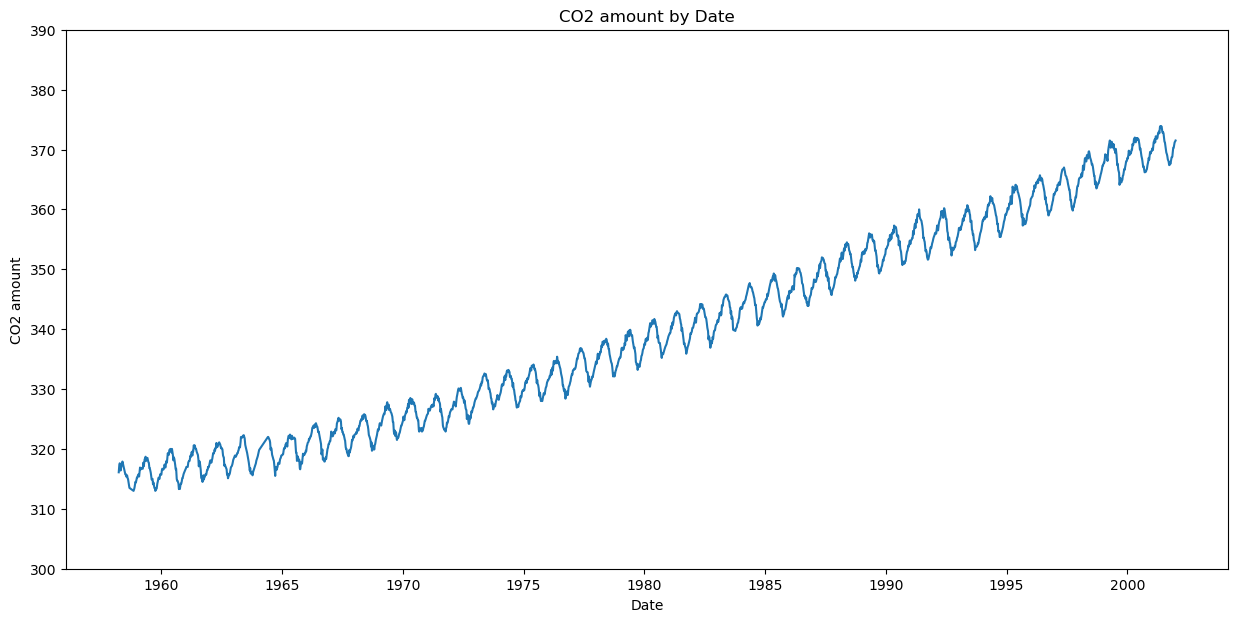

In [123]:
plt.figure(figsize=(15,7))
plt.title("CO2 amount by Date")
plt.xlabel('Date')
plt.ylabel('CO2 amount')
plt.ylim([300, 390])
plt.plot(df_filled.toPandas().set_index('date'))
plt.show()

In [21]:
window_year = Window.partitionBy(F.lit("0")).orderBy(col("date").asc()).rowsBetween(Window.currentRow - 365, Window.currentRow)
df_lagged = (
    df_filled
    .withColumns({"rolling_avg": F.mean(col('co2')).over(window_year),
                 "rolling_std": F.std(col("co2")).over(window_year)
                })
    .dropna(how='any')
)
df_lagged.limit(5)

date,co2,rolling_avg,rolling_std
1958-03-30,316.27142,316.1857147216797,0.12121029021987419
1958-03-31,316.44287,316.2714335123698,0.17143249534354543
1958-04-01,316.6143,316.3571472167969,0.2213144598670864
1958-04-02,316.7857,316.44285888671874,0.27104892439129397
1958-04-03,316.95715,316.52857462565106,0.32071349041659686


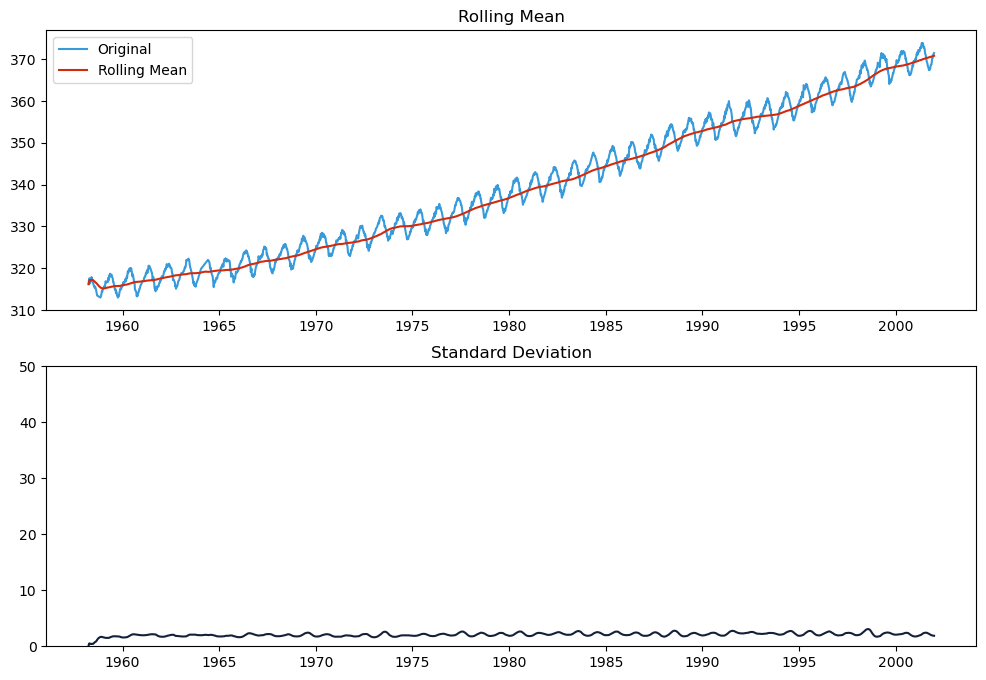

In [22]:
df_pd = df_lagged.toPandas().set_index('date')
fig, (ax_rm, ax_std) = plt.subplots(2, 1, figsize=(12, 8)) 
ax_rm.plot(df_pd["co2"], color='#379BDB', label='Original')
ax_rm.plot(df_pd["rolling_avg"], color='#D22A0D', label='Rolling Mean')
ax_std.plot(df_pd["rolling_std"], color='#142039', label='Rolling Std')
ax_std.set_ylim([0, 50])
ax_rm.legend(loc='best')
ax_rm.set_title('Rolling Mean')
ax_std.set_title('Standard Deviation')
plt.show(block=False)

In [23]:
print('Results of Dickey Fuller Test:')
dftest = adfuller(df_pd['co2'], autolag='AIC')

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
    
print(dfoutput)

Results of Dickey Fuller Test:
Test Statistic                    -1.463008
p-value                            0.551725
#Lags Used                        43.000000
Number of Observations Used    15937.000000
Critical Value (1%)               -3.430760
Critical Value (5%)               -2.861721
Critical Value (10%)              -2.566867
dtype: float64


# Standard ARIMA

In [ ]:
df_month = (
    df_filled
    .withColumn("month", F.trunc(col('date'), "month"))
    .groupby("month").agg(F.round(F.mean(col("co2")), 4).alias("co2"))
    .orderBy(col("month").asc())
).toPandas().set_index("month")

In [53]:
ARIMA_model = pm.auto_arima(df_month['co2'], 
                      start_p=1, 
                      start_q=1,
                      test='adf', # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1, # frequency of series (if m==1, seasonal is set to FALSE automatically)
                      d=1,# let model determine 'd'
                      seasonal=False, # No Seasonality for standard ARIMA
                      trace=False, #logs 
                      error_action='warn', #shows errors ('ignore' silences these)
                      suppress_warnings=True,
                      stepwise=True)

# Model diagnostic
We can interpret the model as a good fit based on the following conditions.

### Standardized residual
```There are no obvious patterns in the residuals, with values having a mean of zero and having a uniform variance.```

### Histogram plus KDE estimate
```The KDE curve should be very similar to the normal distribution (labeled as N(0,1) in the plot)```

### Normal Q-Q
```Most of the data points should lie on the straight line```

### Correlogram (ACF plot)
```95% of correlations for lag greater than zero should not be significant. The grey area is the confidence band, and if values fall outside of this then they are statistically significant. In our case, there are a few values outside of this area, and therefore we may need to add more predictors to make the model more accurate```


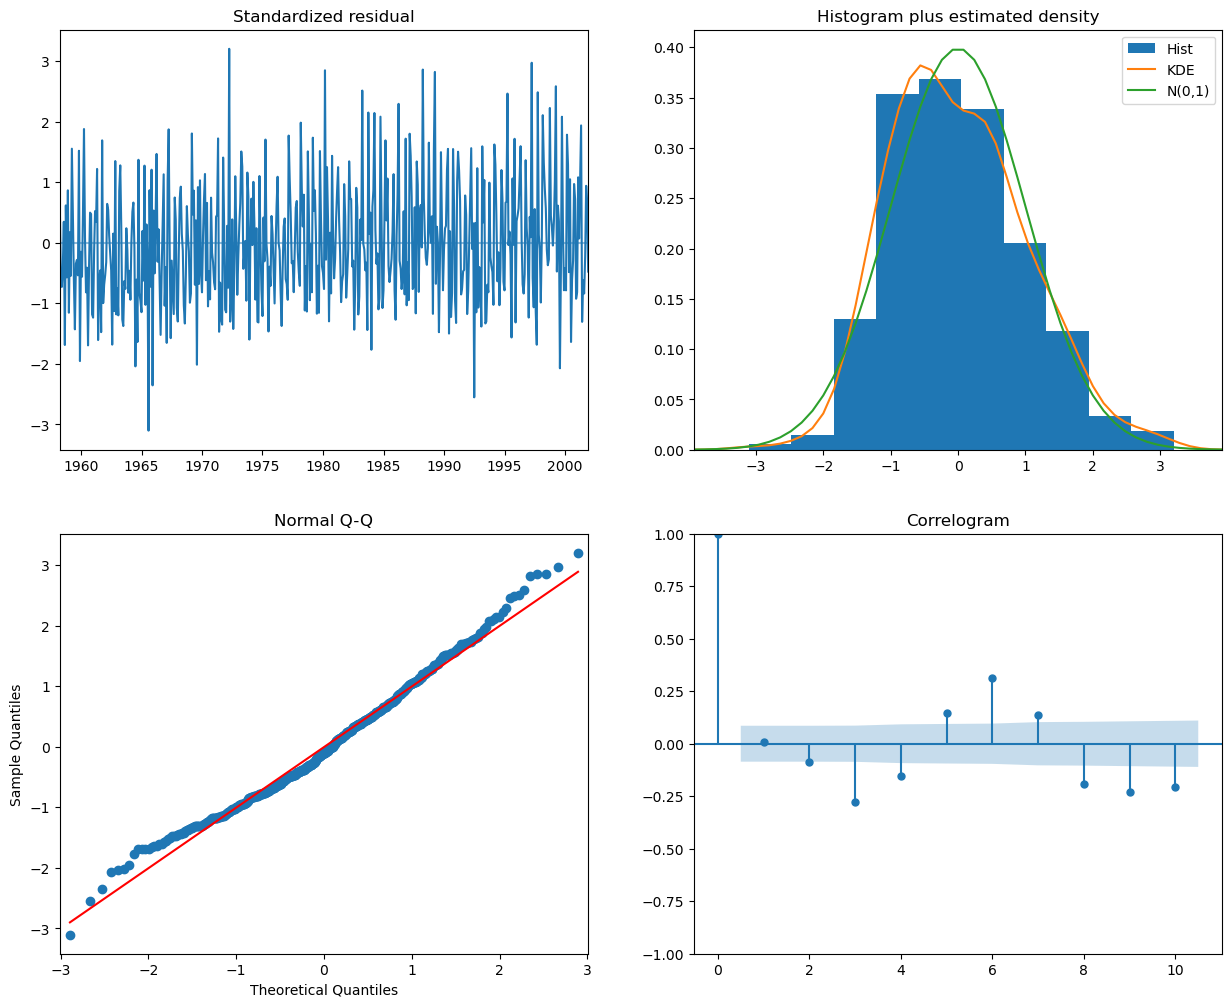

In [54]:
ARIMA_model.plot_diagnostics(figsize=(15,12))
plt.show()

In [29]:
ARIMA_model.arparams

<bound method ARIMA.arparams of ARIMA(order=(3, 1, 3), scoring_args={}, suppress_warnings=True)>

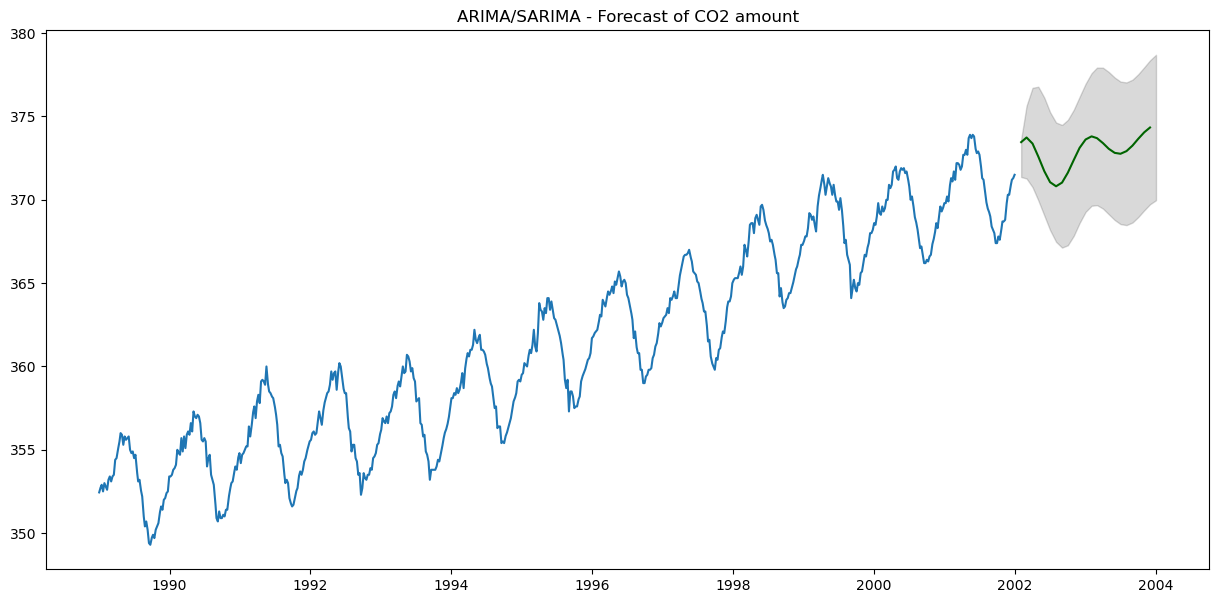

In [55]:
df_predict =df_pd.reset_index().query('date.astype("datetime64[ns]").dt.year > 1988').set_index('date')

def forecast(ARIMA_model, periods=24):
    # Forecast
    n_periods = periods
    fitted, confint = ARIMA_model.predict(n_periods=n_periods, return_conf_int=True)
    index_of_fc = pd.date_range(df_predict.index[-1] + pd.DateOffset(months=1), periods = n_periods, freq='MS')


    # make series for plotting purpose
    fitted_series = pd.Series(fitted, index=index_of_fc)
    lower_series = pd.Series(confint[:, 0], index=index_of_fc)
    upper_series = pd.Series(confint[:, 1], index=index_of_fc)

    # Plot
    plt.figure(figsize=(15,7))
    plt.plot(df_predict["co2"], color='#1f76b4')
    plt.plot(fitted_series, color='darkgreen')
    plt.fill_between(lower_series.index, 
                    lower_series, 
                    upper_series, 
                    color='k', alpha=.15)

    plt.title("ARIMA/SARIMA - Forecast of CO2 amount")
    plt.show()

forecast(ARIMA_model)

# SARIMA
```add seasonality```

In [13]:
df_month = (
    df_filled
    .withColumn("month", F.trunc(col('date'), "month"))
    .groupby("month").agg(F.round(F.mean(col("co2")), 4).alias("co2"))
    .orderBy(col("month").asc())
).toPandas().set_index("month")

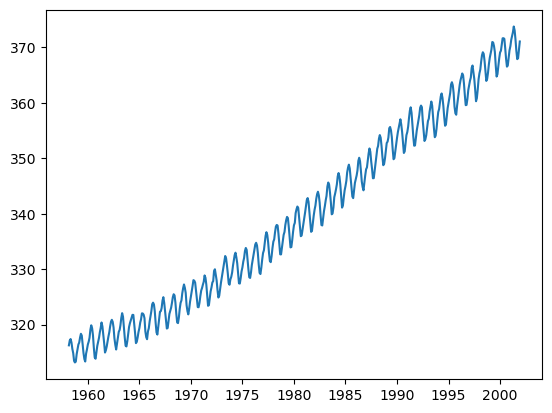

In [18]:
plt.plot(df_month['co2'])
plt.show();

In [16]:
SARIMA_model = pm.auto_arima(df_month["co2"], start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, 
                         m=12, #12 is the frequncy of the cycle
                         start_P=0, 
                         seasonal=True, #set to seasonal
                         d=None, 
                         D=1, #order of the seasonal differencing
                         trace=False,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

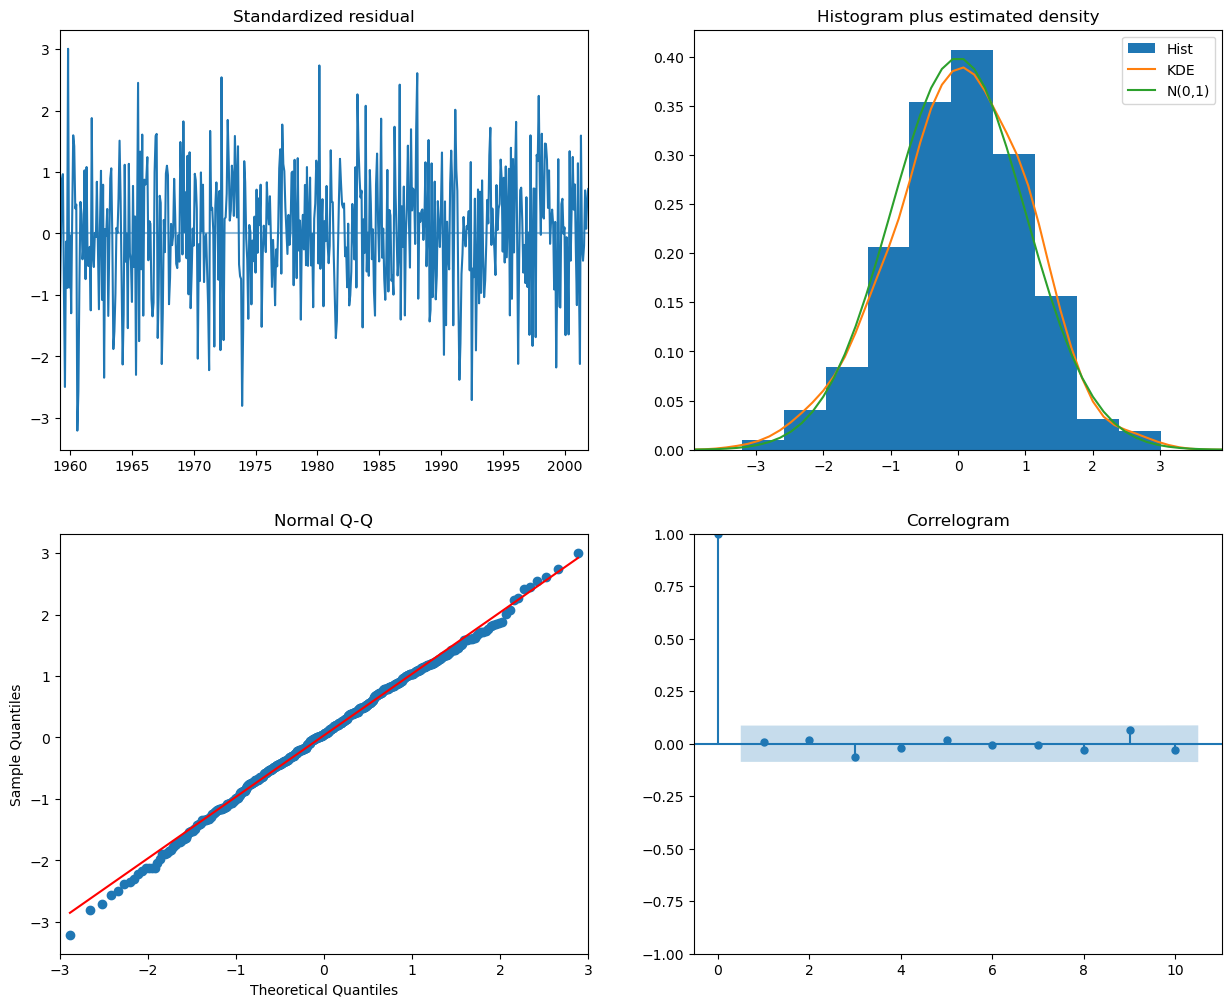

In [17]:
SARIMA_model.plot_diagnostics(figsize=(15,12))
plt.show()

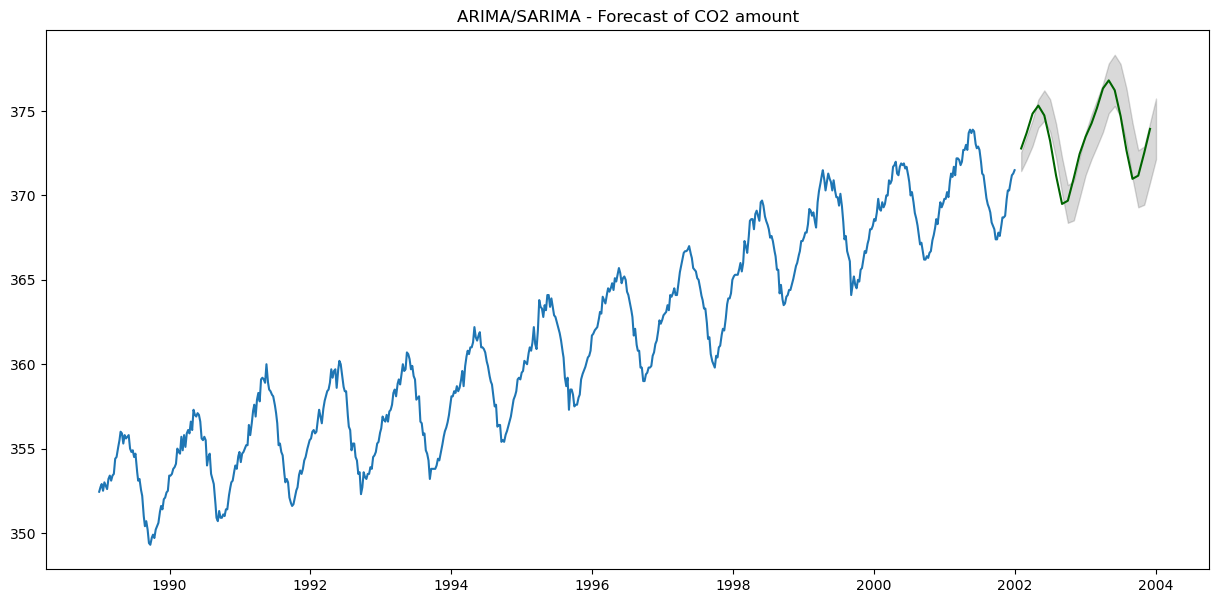

In [26]:
forecast(SARIMA_model)

In [27]:
SARIMA_model.arparams

<bound method ARIMA.arparams of ARIMA(order=(1, 0, 2), scoring_args={}, seasonal_order=(0, 1, 1, 12),
      suppress_warnings=True)>

# SARIMAX model

In [39]:
df_month_index = (
    df_month
    .reset_index()
    .assign(month_index = lambda x: x['month'].astype('datetime64[ns]').dt.month)
    .set_index('month')
)

In [41]:
SARIMAX_model = pm.auto_arima(df_month_index[['co2']], exogenous=df_month_index[['month_index']],
                           start_p=1, start_q=1,
                           test='adf',
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=None, D=1, 
                           trace=False,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

In [44]:
df_month_index.shape

(526, 2)

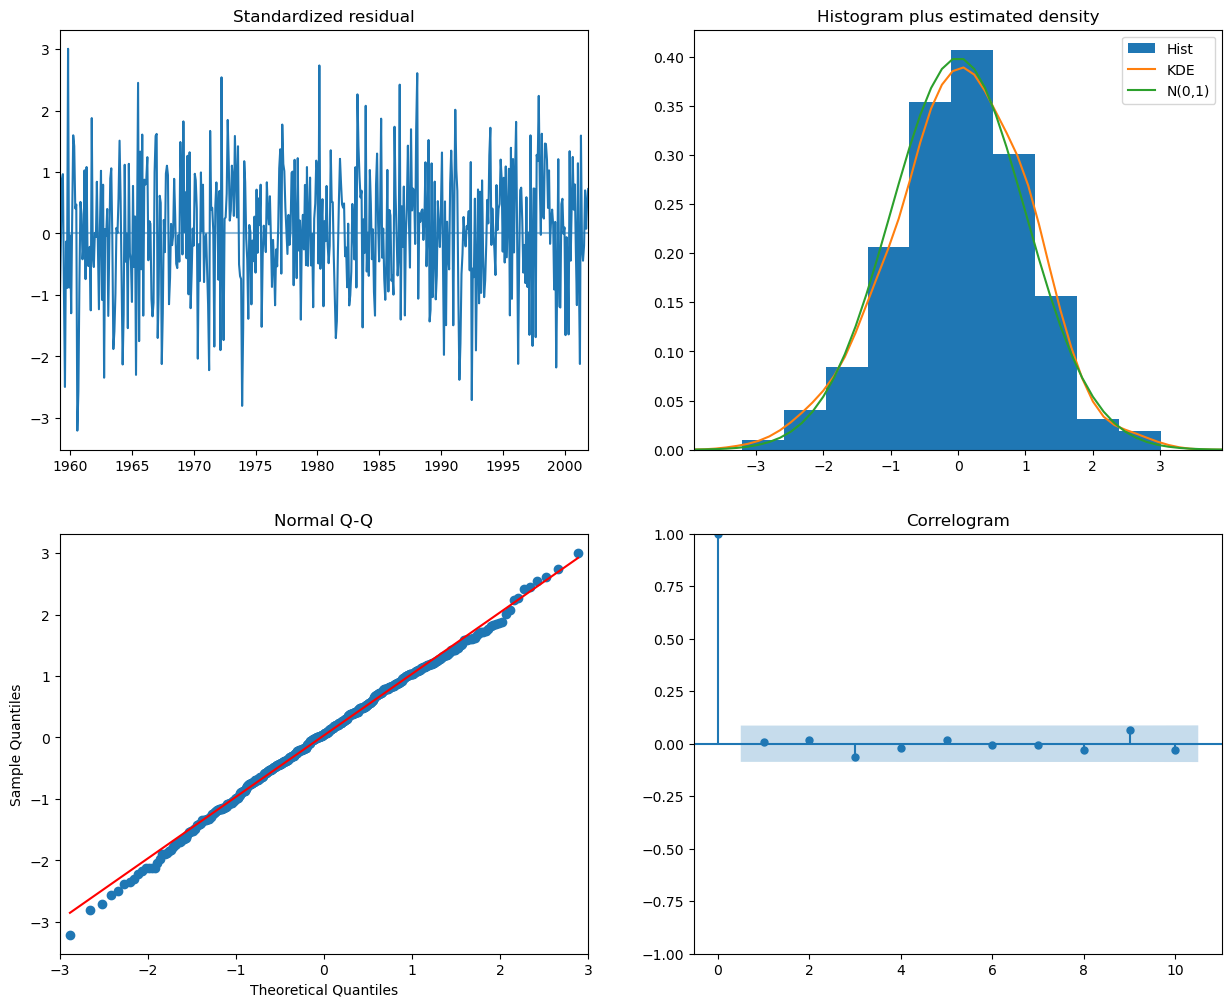

In [52]:
SARIMAX_model.plot_diagnostics(figsize=(15,12));

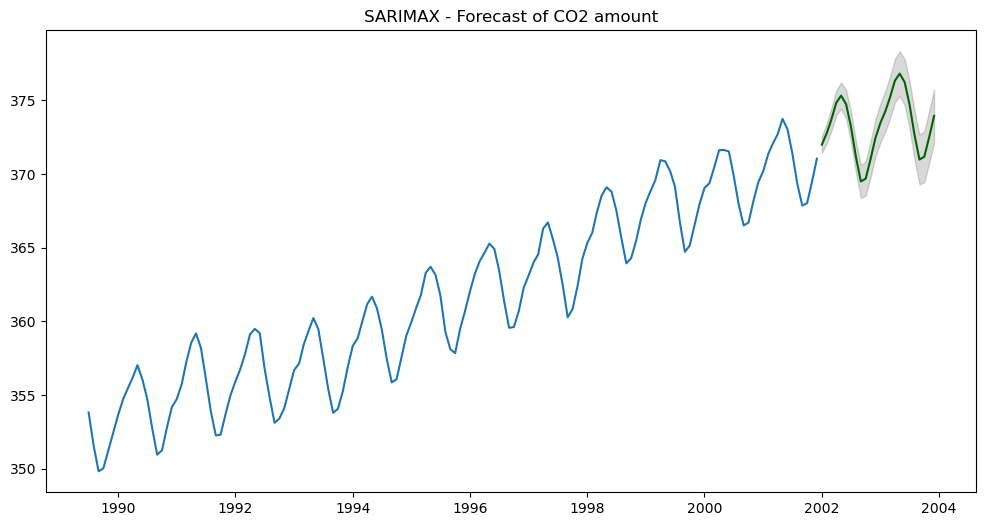

In [49]:
def sarimax_forecast(SARIMAX_model, df, periods=24):
    # Forecast
    n_periods = periods

    forecast_df = pd.DataFrame({"month_index":pd.date_range(df.index[-1], periods = n_periods, freq='MS').month},
                    index = pd.date_range(df.index[-1] + pd.DateOffset(months=1), periods = n_periods, freq='MS'))

    fitted, confint = SARIMAX_model.predict(n_periods=n_periods, 
                                            return_conf_int=True,
                                            exogenous=forecast_df[['month_index']])
    index_of_fc = pd.date_range(df.index[-1] + pd.DateOffset(months=1), periods = n_periods, freq='MS')

    # make series for plotting purpose
    fitted_series = pd.Series(fitted, index=index_of_fc)
    lower_series = pd.Series(confint[:, 0], index=index_of_fc)
    upper_series = pd.Series(confint[:, 1], index=index_of_fc)

    # Plot
    plt.figure(figsize=(12,6))
    plt.plot(df["co2"], color='#1f76b4')
    plt.plot(fitted_series, color='darkgreen')
    plt.fill_between(lower_series.index, 
                    lower_series, 
                    upper_series, 
                    color='k', alpha=.15)

    plt.title("SARIMAX - Forecast of CO2 amount")
    plt.show()

sarimax_forecast(SARIMAX_model, df_month_index.iloc[-150:,:], periods=24)

In [50]:
SARIMAX_model.arparams

<bound method ARIMA.arparams of ARIMA(order=(1, 0, 2), scoring_args={}, seasonal_order=(0, 1, 1, 12),
      suppress_warnings=True)>